In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__name__))))
sys.path.insert(0, SOURCE_DIR)

In [3]:
SOURCE_DIR

'/home/husein/dev/malaya-speech'

In [4]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int
malaya_speech

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


<module 'malaya_speech' from '/home/husein/dev/malaya-speech/malaya_speech/__init__.py'>

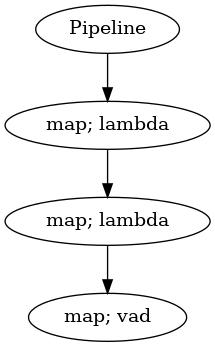

In [5]:
vad_model = malaya_speech.vad.webrtc()
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000))
    .map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(vad_model)
)
p_vad.visualize()

In [6]:
model = malaya_speech.stt.transducer.pt_transformer(model = 'mesolitica/conformer-medium',
                                                   local_files_only=True)

In [7]:
_ = model.cuda()
_ = model.eval()

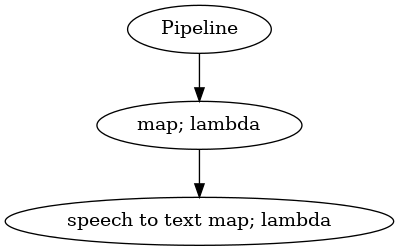

In [8]:
p_asr = Pipeline()
pipeline_asr = (
    p_asr.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000))
    .map(lambda x: model([x])[0][0], name = 'speech-to-text')
)
p_asr.visualize()

In [9]:
speaker_v = malaya_speech.speaker_vector.nemo(model = 'huseinzol05/nemo-titanet_large', 
                                              local_files_only=True)

_ = speaker_v.cuda()
_ = speaker_v.eval()

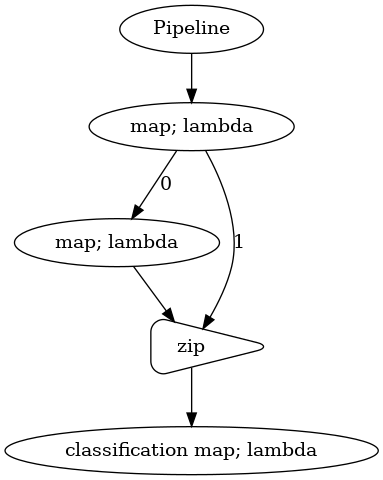

In [10]:
speakers = {}

p_classification = Pipeline()
to_float = p_classification
vector = to_float.map(lambda x: speaker_v([x])[0])
speaker = vector.map(lambda x: streaming_speaker_similarity(x, speakers = speakers, similarity_threshold = 0.7))
vector.zip(speaker).map(lambda x: x, name = 'classification')

p_classification.visualize()

In [11]:
from malaya_speech.diarization import streaming_speaker_similarity
import numpy as np

In [12]:
speaker_overlap = malaya_speech.speaker_overlap.deep_model(model = 'vggvox-v2',
                                                          local_files_only=True,
                                                          device = 'gpu:0')

2023-03-01 23:22:29.624459: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 23:22:29.625346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 23:22:29.631249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 23:22:29.632048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [13]:
is_clean = malaya_speech.is_clean.nemo(model = 'huseinzol05/nemo-is-clean-speakernet')
_ = is_clean.cuda()
_ = is_clean.eval()

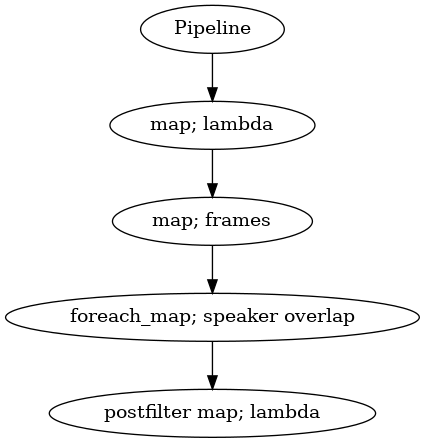

In [14]:
p_postfilter = Pipeline()
p_frames = p_postfilter.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000)) \
.map(malaya_speech.utils.generator.frames, frame_duration_ms = 100, 
                     append_ending_trail = False)
p_speaker_overlap = p_frames.foreach_map(speaker_overlap) \
.map(lambda x: np.mean(x) <= 0.1, name = 'postfilter')
p_postfilter.visualize()

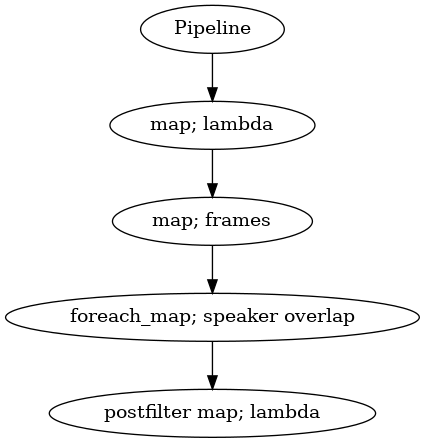

In [15]:
p_postfilter = Pipeline()
p_frames = p_postfilter.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000)) \
.map(malaya_speech.utils.generator.frames, frame_duration_ms = 100, 
                     append_ending_trail = False)
p_speaker_overlap = p_frames.foreach_map(speaker_overlap) \
.map(lambda x: np.mean(x) <= 0.1, name = 'postfilter')
p_postfilter.visualize()

In [16]:
noise_reduction = malaya_speech.noise_reduction.deep_model(model = 'resnet-unet', device = 'gpu:0')
resnet = malaya_speech.speech_enhancement.deep_enhance(model = 'resnet-unet', device = 'gpu:0')

2023-03-01 23:22:34.756848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 23:22:34.757743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 23:22:34.758467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 23:22:34.758938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 23:22:34.759366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

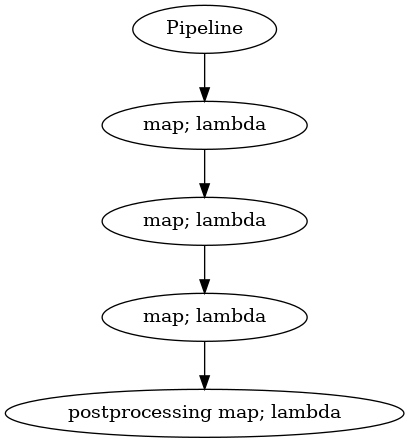

In [17]:
p_postprocessing = Pipeline()
p_postprocessing.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 44100)) \
.map(lambda x: noise_reduction(x)['voice']) \
.map(lambda x: malaya_speech.resample(x, old_samplerate = 44100, new_samplerate = 22050)) \
.map(lambda x: resnet(x), name = 'postprocessing')
p_postprocessing.visualize()

In [18]:
y = malaya_speech.load('/home/husein/dev/malaya-speech/speech/example-speaker/husein-zolkepli.wav', sr = 22050)[0]

In [22]:
p_asr(y)

{'<lambda>': array([ 9.64118418e-05,  4.94132065e-05, -2.42195808e-06, ...,
        -9.64161226e-05, -9.64130164e-05,  0.00000000e+00]),
 'speech-to-text': ('testing nama saya husin bin zulkifli',
  [0.1963536524603048],
  [127, 337, 185, 232, 31, 432, 40, 34, 306, 602, 204, 178, 124, 51])}

In [20]:
p_postfilter(y)['postfilter']

2023-03-01 23:22:58.918934: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2023-03-01 23:22:58.920205: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-01 23:22:59.124244: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


True

In [21]:
p_postprocessing(y)['postprocessing']

array([ 0.00246986,  0.00060934, -0.00040041, ...,  0.00045583,
        0.00041816,  0.00043776], dtype=float32)

In [23]:
from glob import glob

youtubes = sorted(glob('/home/husein/ssd2/youtube/audio/*.mp3'))
len(youtubes)

6081

In [24]:
from unidecode import unidecode
import torchaudio
import torch
import pickle

In [25]:
parent_dir = '/home/husein/ssd2/processed-youtube-v2'
!rm -rf {parent_dir}
!mkdir {parent_dir}

In [26]:
parent_dir_done = '/home/husein/ssd2/processed-youtube-done-v2'
!rm -rf {parent_dir_done}
!mkdir {parent_dir_done}

In [27]:
from tqdm import tqdm

In [ ]:
for f in tqdm(youtubes):
    
    new_f = unidecode(os.path.split(f)[1].replace('.mp3', '').replace(' ', '_'))
    f_done = os.path.join(parent_dir_done, new_f)
    
    if os.path.exists(f_done):
        continue
    
    speakers = {}
    samples = malaya_speech.streaming.torchaudio.stream(f,
                                                        vad_model = p_vad, 
                                                        postprocessing_model = p_postprocessing,
                                                        postfilter_model = p_postfilter,
                                                        asr_model = p_asr,
                                                        classification_model = p_classification,
                                                        segment_length = 441,
                                                        realtime_print = False,
                                                        sample_rate = 22050,
                                                        min_length = 1.0,
                                                        max_length = 12.0)
    
    if len(samples):
        
        parent_new_f = os.path.join(parent_dir, new_f)
        os.makedirs(parent_new_f, exist_ok=True)

        for i in range(len(samples)):
            audio_path = os.path.join(parent_new_f, f'{i}.mp3')
            torchaudio.save(audio_path, 
                            torch.tensor(samples[i]['wav_data'].astype('float32')).unsqueeze(0), 
                            22050, format='mp3')
            samples[i]['wav_data'] = audio_path

        with open(f'{parent_new_f}.pkl', 'wb') as fopen:
            pickle.dump(samples, fopen)
            
    with open(f_done, 'w') as fopen:
        fopen.write('done')

 90%|████████████████████████████████████████████████████████████████████████████████▎        | 5484/6081 [17:05:59<42:52:55, 258.59s/it]

In [29]:
samples

[{'wav_data': '/home/husein/ssd2/processed-youtube-v2/#AdaApaDenganAMAN-j9UvNftUQWg/0.mp3',
  'timestamp': datetime.datetime(2023, 3, 1, 23, 23, 6, 765238),
  'asr_model': ('aku rindulah', [0.8347153507671368], [58, 459, 34, 147, 14]),
  'classification_model': (array([ 0.01049698, -0.0108043 ,  0.01538327,  0.00504291, -0.01382606,
           0.01714464,  0.02798939,  0.01082467,  0.04116365, -0.00686073,
          -0.00525264,  0.00716306, -0.02104593,  0.02061796, -0.00318122,
          -0.00484706,  0.01492582,  0.01005818, -0.02725526,  0.04090821,
           0.00631056, -0.00823523,  0.00819214,  0.008606  , -0.01387715,
           0.00799453, -0.03576055,  0.03796734, -0.00316636,  0.00524763,
           0.00301951, -0.02206993,  0.01901717,  0.00541636,  0.01410729,
          -0.01387191,  0.0018813 , -0.01074336, -0.02229442,  0.00548023,
           0.01692368,  0.01987764, -0.00349152,  0.01277359, -0.01082668,
           0.00202184,  0.01644643, -0.01375372,  0.01023165,  0.

In [30]:
from datasets import Audio

reader = Audio(sampling_rate = 22050)

In [31]:
audio = reader.decode_example(reader.encode_example(samples[10]['wav_data']))['array']
processed = p_postprocessing(audio)['postprocessing']

In [32]:
import IPython.display as ipd
ipd.Audio(audio, rate = 22050)

In [33]:
ipd.Audio(processed, rate = 22050)